In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyp

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0_thin": 5.0,
    "Rd_thin": 2.5,
    "Sigma0_thin": 100.0,
    "RsigR_thin": 8.0,
    "RsigZ_thin": 8.0,
    "sigmaR0_R0_thin": 40.0,
    "sigmaz0_R0_thin": 25.0,
    "L0_thin": 50.0,
    "Rinit_for_Rc_thin": 8.0,
    "R0_thick": 8.0,
    "Rd_thick": 2.0,
    "Sigma0_thick": 150.0,
    "RsigR_thick": 8.0,
    "RsigZ_thick": 4.0,
    "sigmaR0_R0_thick": 60.0,
    "sigmaz0_R0_thick": 40.0,
    "L0_thick": 50.0,
    "Rinit_for_Rc_thick": 8.0,
    "f_thin": 0.5,
    "f_thick": 0.2,
    "f_spheroid": 0.3,
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

In [3]:
envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

In [4]:
Phi_thin = miyamoto_nagai_potential
Phi_thick = miyamoto_nagai_potential
Phi_spheroid = plummer_potential
Phi_halo = plummer_potential

theta_thin = jnp.array([1e12, 50.0, 200.0]) # (M, a, b) z.B. für Miyamoto–Nagai
theta_thick = jnp.array([1e12, 100.0, 200.0]) # (M, a, b) z.B. für Miyamoto–Nagai
theta_spheroid = jnp.array([1e12, 50.0]) # (M, a) z.B. für Plummer
theta_halo = jnp.array([1e13, 100.0]) # (M, a) z.B. für Plummer

In [5]:
#Generate candidate actions
candidates, samples, soft_weights = sampling.sample_df_potential(distributionfunction.distributionfunction_combined, key, params, Phi_thin, Phi_thick, Phi_spheroid, theta_thin, theta_thick, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

Number of candidate actions: 500000


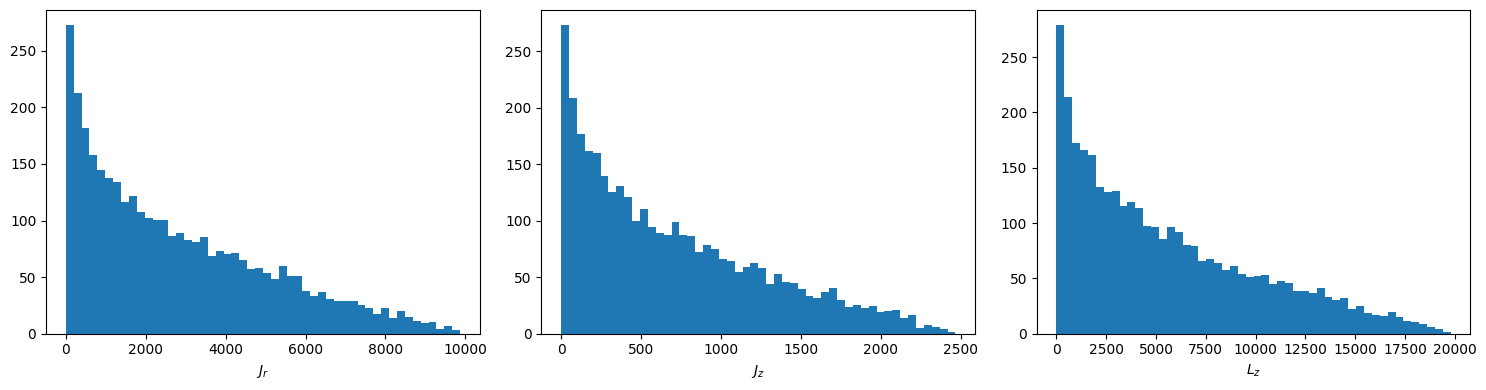

In [6]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

In [7]:
theta = (theta_thin, theta_thick, theta_spheroid, theta_halo)
def combined_potential(x, y, z, *theta):
    # Unpack the parameters for each potential
    theta_thin, theta_thick, theta_spheroid, theta_halo = theta

    # Compute the contributions from each potential
    Phi_thin_val = miyamoto_nagai_potential(x, y, z, *theta_thin)
    Phi_thick_val = miyamoto_nagai_potential(x, y, z, *theta_thick)
    Phi_spheroid_val = plummer_potential(x, y, z, *theta_spheroid)
    Phi_halo_val = plummer_potential(x, y, z, *theta_halo)

    # Return the total potential
    return Phi_thin_val + Phi_thick_val + Phi_spheroid_val + Phi_halo_val
Phi = combined_potential

In [8]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)

Phase-space coordinates shape: (500000, 6)


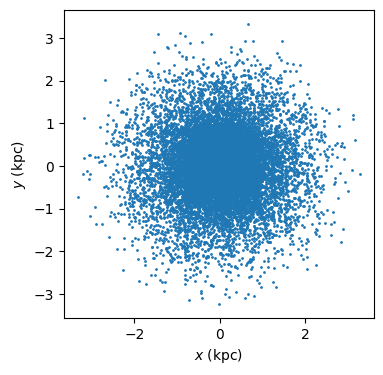

In [9]:
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

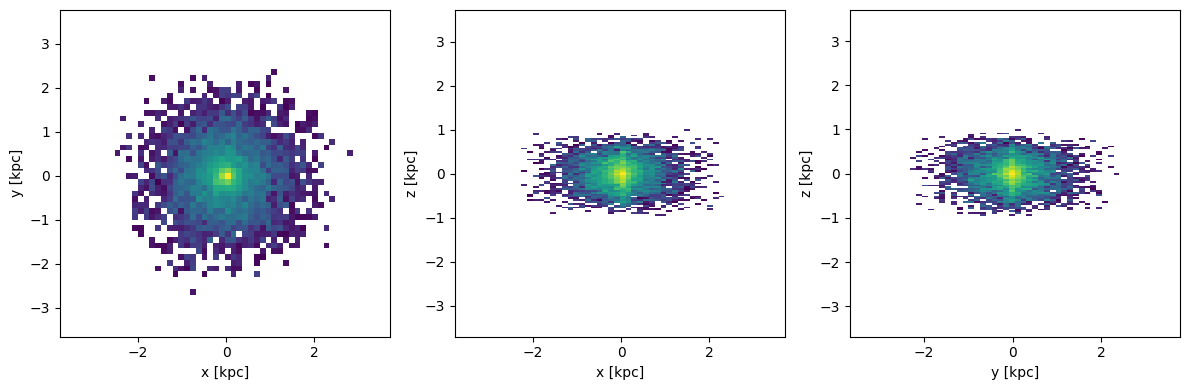

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

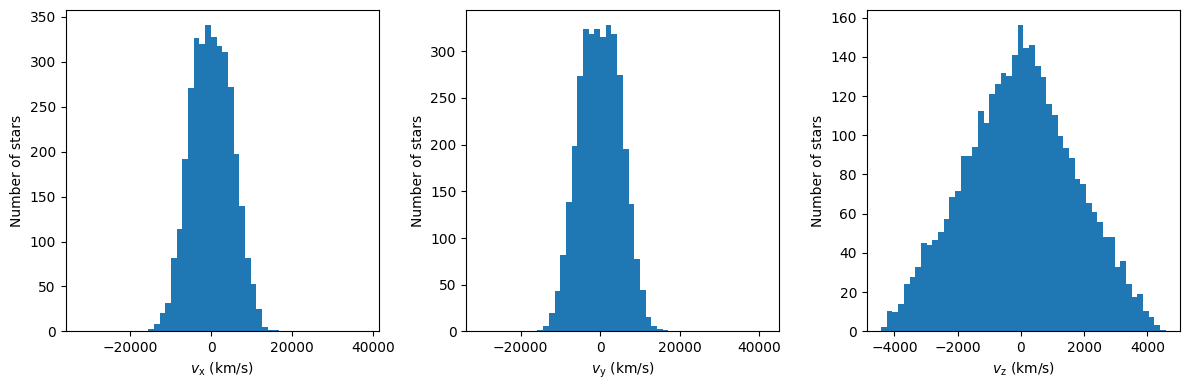

In [11]:
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

R = jnp.sqrt(x**2 + y**2)
mask = R > 0.0
v_x_masked = v_x[mask]
v_y_masked = v_y[mask]
v_z_masked = v_z[mask]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(v_x_masked, bins=50, weights=soft_weights[mask])#, range=(-500, 500))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")


plt.subplot(1,3,2)
plt.hist(v_y_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(1,3,3)
plt.hist(v_z_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

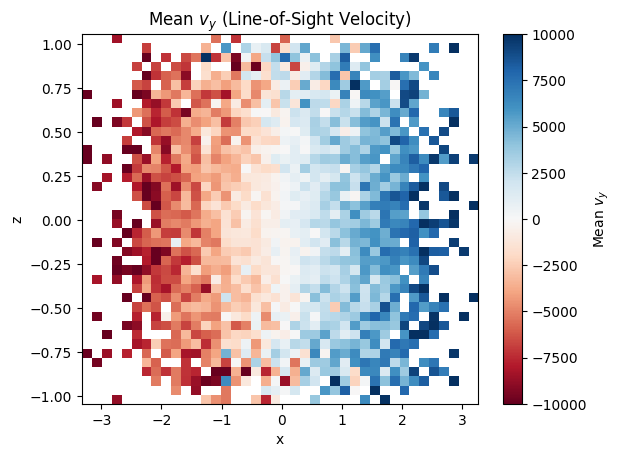

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y[mask], weights=soft_weights[mask])

# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu', vmin=-10000, vmax=10000)#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()